Raw data to Structured data for maodelling

In [ ]:
# Step 0: Upload file from local system
from google.colab import files
uploaded = files.upload()

# Step 1: Install and import packages
!pip install missingno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import zscore
import os

# Step 2: Setup output directory
output_dir = "colab_outputs"
os.makedirs(output_dir, exist_ok=True)

# Step 3: Read uploaded file
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# Step 4: Convert datetime columns (adjust column names if needed)
datetime_cols = ['First Response Time', 'Time to Resolution']
for col in datetime_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Step 5: Initial missing value plot
msno.bar(data, color='dodgerblue', figsize=(10,5))
plt.savefig(f"{output_dir}/missing_before.png")
plt.close()

# Step 6: Handle missing values
fill_values = {
    'Resolution': 'Not Provided',
    'Customer Satisfaction Rating': data['Customer Satisfaction Rating'].median() if 'Customer Satisfaction Rating' in data.columns else np.nan
}
data.fillna(value=fill_values, inplace=True)

# Fill datetime columns with their median
for col in datetime_cols:
    if col in data.columns:
        median_dt = data[col].dropna().median()
        data[col] = data[col].fillna(median_dt)

# Replace placeholders
data.replace(['Unknown', 'NA', '-'], np.nan, inplace=True)

# Step 7: Post-cleaning missing value plot
msno.bar(data, color='forestgreen', figsize=(10,5))
plt.savefig(f"{output_dir}/missing_after.png")
plt.close()

# Step 8: Numeric summary
desc_summary = data.describe(include='number').T
desc_summary.to_csv(f"{output_dir}/numeric_summary.csv")

# Step 9: Handle outliers for numeric columns
numeric_cols = desc_summary.index.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=data[col], color='orange')
    plt.title(f"Boxplot of {col}")
    plt.savefig(f"{output_dir}/boxplot_{col}.png")
    plt.close()

# Optional cap for age-related column
for col in numeric_cols:
    if 'age' in col.lower():
        data.loc[data[col] > 70, col] = 70
        data.loc[data[col] < 18, col] = 18

# Remove rows with extreme z-scores
z_scores = np.abs(zscore(data[numeric_cols], nan_policy='omit'))
outliers = (z_scores > 3).any(axis=1)
print(f"Outliers detected: {outliers.sum()}")
data = data[~outliers]

# Step 10: Save cleaned dataset
cleaned_file = f"{output_dir}/cleaned_customer_support.csv"
data.to_csv(cleaned_file, index=False)
print("Cleaned dataset saved:", cleaned_file)

# Step 11: Download file to local system
files.download(cleaned_file)


Saving customer_support_tickets.csv to customer_support_tickets (2).csv
Outliers detected: 0
Cleaned dataset saved: colab_outputs/cleaned_customer_support.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Complete detailed EDA

In [ ]:
# Step 0: Upload CSV file
from google.colab import files
uploaded = files.upload()

# Step 1: Install and import libraries
!pip install missingno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import os

# Setup consistent theme
sns.set(style='whitegrid', palette='muted')
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

# Step 2: Setup output directory
output_dir = "eda_outputs"
os.makedirs(output_dir, exist_ok=True)

# Step 3: Load dataset
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Step 4: Convert datetime columns
datetime_cols = ['First Response Time', 'Time to Resolution']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 5: Overview of structure
print("🔹 Dataset Shape:", df.shape)
print("\n🔹 Column Types:")
print(df.dtypes)

# Step 6: Missing Data Visualization
msno.bar(df, color='royalblue', figsize=(10, 5), fontsize=12)
plt.title("Missing Data Overview")
plt.savefig(f"{output_dir}/missing_data_overview.png")
plt.close()

# Step 7: Basic Statistics
desc = df.describe(include='number').T
desc['missing_values (%)'] = df.isnull().mean().round(4) * 100
desc.to_csv(f"{output_dir}/numeric_summary.csv")
print("\n🔹 Summary of Numeric Columns:")
print(desc)

# Step 8: Distribution Plots
for col in desc.index:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], kde=True, color='royalblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.savefig(f"{output_dir}/distplot_{col}.png")
    plt.close()

# Step 9: Boxplots to Detect Outliers
for col in desc.index:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col], color='royalblue')
    plt.title(f"Boxplot of {col}")
    plt.savefig(f"{output_dir}/boxplot_{col}.png")
    plt.close()

# Step 10: Correlation Matrix
plt.figure(figsize=(10,8))
corr = df[desc.index].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig(f"{output_dir}/correlation_heatmap.png")
plt.close()

# Step 11: Key Insights
print("\n🔍 Key Insights:")
top_missing = desc['missing_values (%)'].sort_values(ascending=False)
print(f"- Highest missing data in: {top_missing.index[0]} ({top_missing.iloc[0]}%)")
print(f"- Most correlated feature pair: {corr.stack().drop_duplicates().sort_values(ascending=False)[1:2].index[0]}")
print(f"- Column with widest range: {desc['max'].subtract(desc['min']).idxmax()} (Range: {desc['max'].subtract(desc['min']).max()})")

# Step 12: Save cleaned version for modeling
df.to_csv(f"{output_dir}/eda_cleaned.csv", index=False)
files.download(f"{output_dir}/eda_cleaned.csv")


Saving cleaned_customer_support.csv to cleaned_customer_support.csv
🔹 Dataset Shape: (8469, 17)

🔹 Column Types:
Ticket ID                                int64
Customer Name                           object
Customer Email                          object
Customer Age                             int64
Customer Gender                         object
Product Purchased                       object
Date of Purchase                        object
Ticket Type                             object
Ticket Subject                          object
Ticket Description                      object
Ticket Status                           object
Resolution                              object
Ticket Priority                         object
Ticket Channel                          object
First Response Time             datetime64[ns]
Time to Resolution              datetime64[ns]
Customer Satisfaction Rating           float64
dtype: object

🔹 Summary of Numeric Columns:
                               count       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 0: Upload CSV file
from google.colab import files
uploaded = files.upload()

# Step 1: Install and import packages
!pip install missingno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import os

# Styling setup
sns.set(style='whitegrid', palette='muted')
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

# Step 2: Setup output directory
output_dir = "eda_report"
os.makedirs(output_dir, exist_ok=True)

# Step 3: Load file
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Step 4: Convert relevant timestamps
datetime_cols = ['First Response Time', 'Time to Resolution']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 5: Show basic info
print(f"🔹 Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
print("\n🔹 Column Types:\n", df.dtypes)

# Step 6: Missing values heatmap
plt.figure(figsize=(10, 5))
msno.bar(df, color='royalblue', fontsize=12)
plt.title("Missing Data Overview", fontsize=14)
plt.savefig(f"{output_dir}/missing_data_overview.png")
plt.close()
plt.show()


# Step 7: Summary statistics
num_summary = df.describe(include='number').T
num_summary['missing (%)'] = df[num_summary.index].isnull().mean().round(4) * 100
num_summary.to_csv(f"{output_dir}/numeric_summary.csv")
print("\n🔹 Numeric Summary:\n", num_summary)
plt.show()


# Step 8: Distribution histograms
for col in num_summary.index:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], kde=True, color='royalblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.savefig(f"{output_dir}/histogram_{col}.png")
    plt.close()
plt.show()

# Step 9: Boxplots for outlier detection
for col in num_summary.index:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col], color='royalblue')
    plt.title(f"Boxplot of {col}")
    plt.savefig(f"{output_dir}/boxplot_{col}.png")
    plt.close()
plt.show()

# Step 10: Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[num_summary.index].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig(f"{output_dir}/correlation_heatmap.png")
plt.close()
plt.show()

# Step 11: Extract and display insights
print("\n🔍 Key Insights:")
# Top missing column
top_missing = num_summary['missing (%)'].sort_values(ascending=False)
print(f"- Most missing: {top_missing.index[0]} ({top_missing.iloc[0]}%)")
plt.show()

# Strongest correlation pair (excluding perfect self-pairs)
stacked_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
if not stacked_corr.empty:
    top_corr_pair = stacked_corr.sort_values(ascending=False).index[0]
    top_corr_value = stacked_corr.sort_values(ascending=False).iloc[0]
    print(f"- Strongest correlation: {top_corr_pair} ({top_corr_value:.2f})")
plt.show()

# Widest value spread
spread = num_summary['max'] - num_summary['min']
widest = spread.idxmax()
print(f"- Widest numeric range: {widest} (Range: {spread.max():.2f})")
plt.show()

# Step 12: Export cleaned dataset
df.to_csv(f"{output_dir}/cleaned_customer_support.csv", index=False)
files.download(f"{output_dir}/cleaned_customer_support.csv")
plt.show()


Saving cleaned_customer_support (1).csv to cleaned_customer_support (1) (1).csv
🔹 Dataset contains 8469 rows and 17 columns.

🔹 Column Types:
 Ticket ID                                int64
Customer Name                           object
Customer Email                          object
Customer Age                             int64
Customer Gender                         object
Product Purchased                       object
Date of Purchase                        object
Ticket Type                             object
Ticket Subject                          object
Ticket Description                      object
Ticket Status                           object
Resolution                              object
Ticket Priority                         object
Ticket Channel                          object
First Response Time             datetime64[ns]
Time to Resolution              datetime64[ns]
Customer Satisfaction Rating           float64
dtype: object

🔹 Numeric Summary:
                        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving cleaned_customer_support.csv to cleaned_customer_support.csv
🔹 Dataset contains 8469 rows and 17 columns.

🔹 Column Types:
 Ticket ID                                int64
Customer Name                           object
Customer Email                          object
Customer Age                             int64
Customer Gender                         object
Product Purchased                       object
Date of Purchase                        object
Ticket Type                             object
Ticket Subject                          object
Ticket Description                      object
Ticket Status                           object
Resolution                              object
Ticket Priority                         object
Ticket Channel                          object
First Response Time             datetime64[ns]
Time to Resolution              datetime64[ns]
Customer Satisfaction Rating           float64
dtype: object


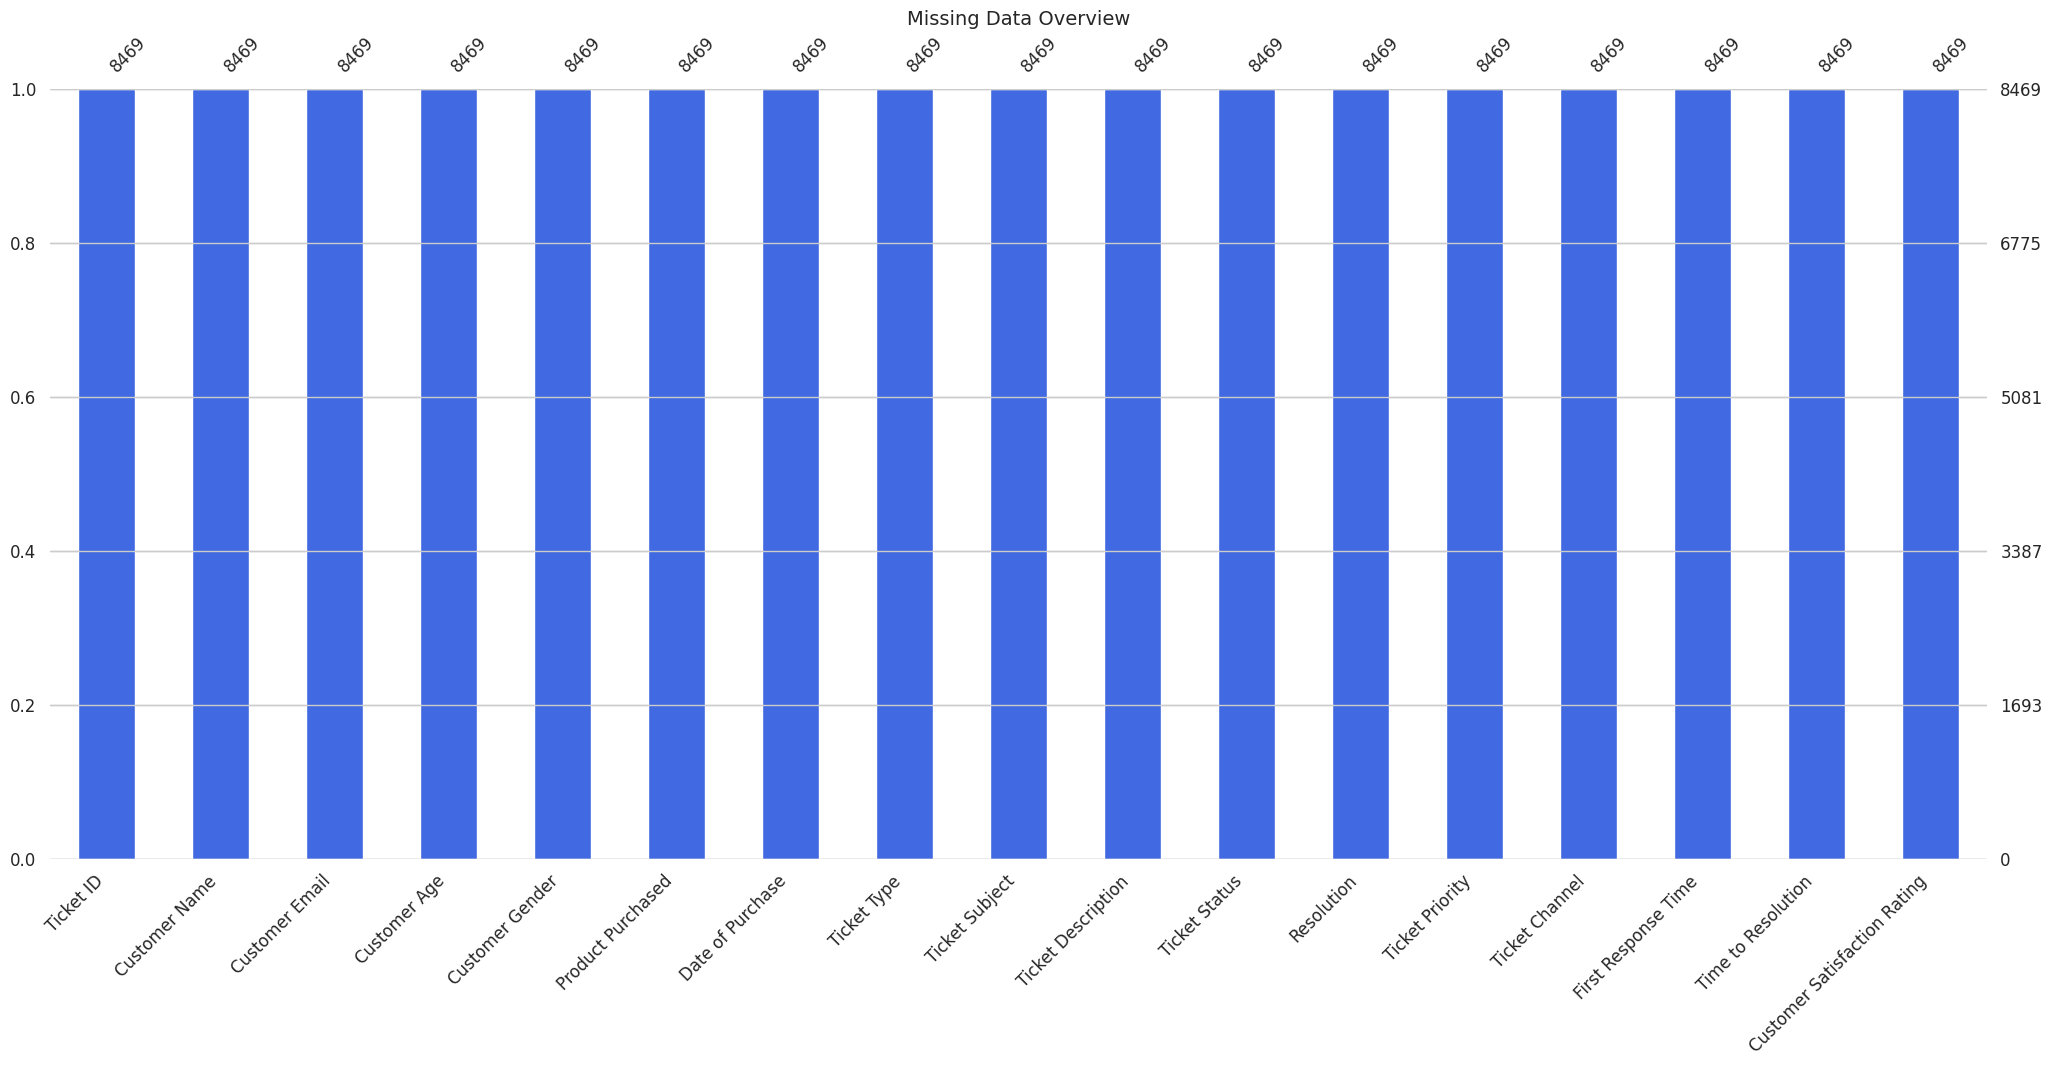


🔹 Numeric Summary:
                                count         mean          std   min     25%  \
Ticket ID                     8469.0  4235.000000  2444.934048   1.0  2118.0   
Customer Age                  8469.0    44.026804    15.296112  18.0    31.0   
Customer Satisfaction Rating  8469.0     2.997166     0.804446   1.0     3.0   

                                 50%     75%     max  missing (%)  
Ticket ID                     4235.0  6352.0  8469.0          0.0  
Customer Age                    44.0    57.0    70.0          0.0  
Customer Satisfaction Rating     3.0     3.0     5.0          0.0  


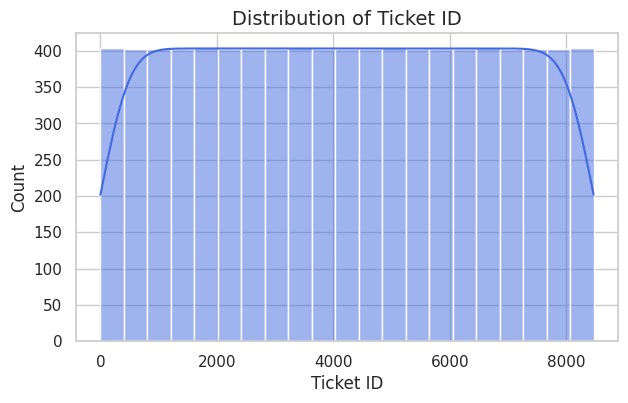

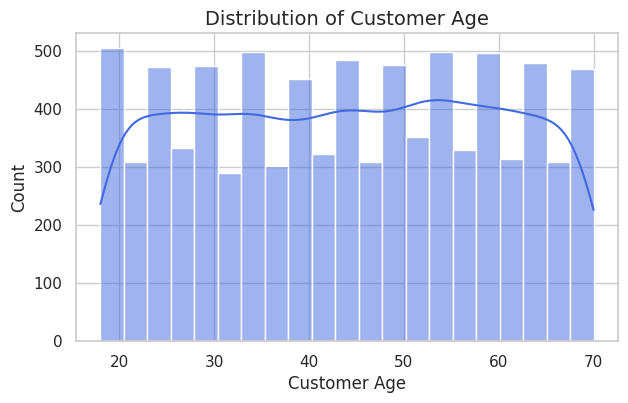

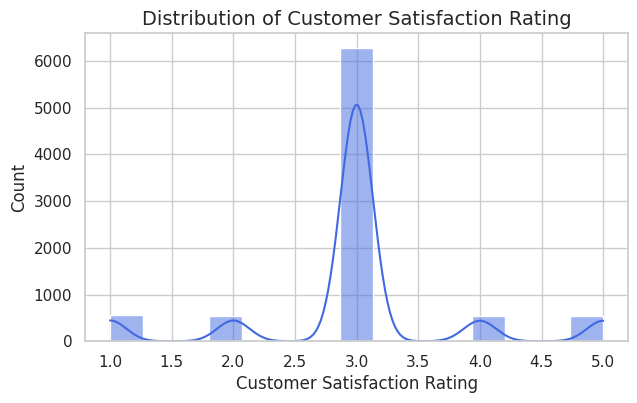

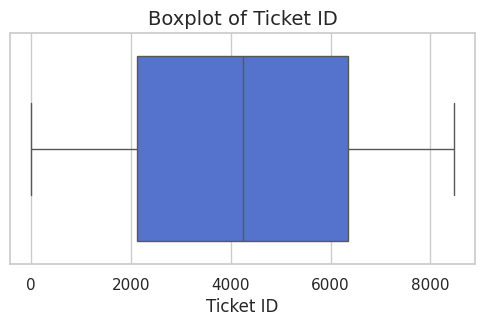

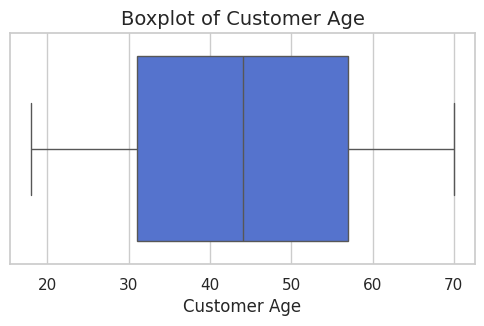

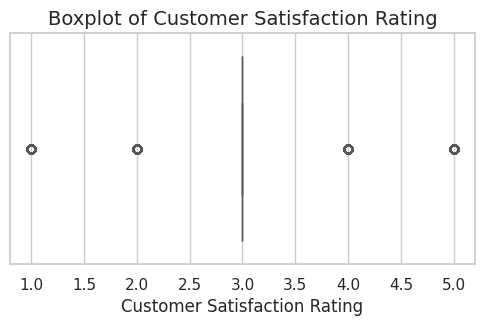

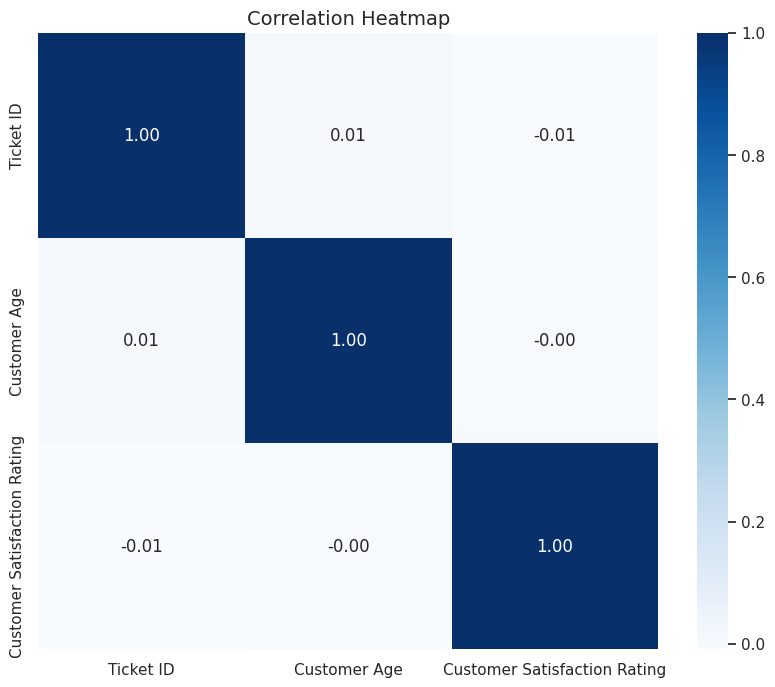


🔍 Key Insights:
- Most missing: Ticket ID (0.0%)
- Strongest correlation: ('Ticket ID', 'Customer Age') (0.01)
- Widest numeric range: Ticket ID (Range: 8468.00)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 0: Upload CSV file
from google.colab import files
uploaded = files.upload()

# Step 1: Install and import packages
!pip install missingno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import os

# Styling setup
sns.set(style='whitegrid', palette='muted')
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

# Step 2: Setup output directory
output_dir = "eda_report"
os.makedirs(output_dir, exist_ok=True)

# Step 3: Load file
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Step 4: Convert relevant timestamps
datetime_cols = ['First Response Time', 'Time to Resolution']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 5: Show basic info
print(f"🔹 Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
print("\n🔹 Column Types:\n", df.dtypes)

# Step 6: Missing values heatmap
plt.figure(figsize=(10, 5))
msno.bar(df, color='royalblue', fontsize=12)
plt.title("Missing Data Overview", fontsize=14)
plt.savefig(f"{output_dir}/missing_data_overview.png")
plt.show()

# Step 7: Summary statistics
num_summary = df.describe(include='number').T
num_summary['missing (%)'] = df[num_summary.index].isnull().mean().round(4) * 100
num_summary.to_csv(f"{output_dir}/numeric_summary.csv")
print("\n🔹 Numeric Summary:\n", num_summary)

# Step 8: Distribution histograms
for col in num_summary.index:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], kde=True, color='royalblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.savefig(f"{output_dir}/histogram_{col}.png")
    plt.show()

# Step 9: Boxplots for outlier detection
for col in num_summary.index:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col], color='royalblue')
    plt.title(f"Boxplot of {col}")
    plt.savefig(f"{output_dir}/boxplot_{col}.png")
    plt.show()

# Step 10: Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[num_summary.index].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig(f"{output_dir}/correlation_heatmap.png")
plt.show()

# Step 11: Extract and display insights
print("\n🔍 Key Insights:")
# Top missing column
top_missing = num_summary['missing (%)'].sort_values(ascending=False)
print(f"- Most missing: {top_missing.index[0]} ({top_missing.iloc[0]}%)")

# Strongest correlation pair (excluding perfect self-pairs)
stacked_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
if not stacked_corr.empty:
    top_corr_pair = stacked_corr.sort_values(ascending=False).index[0]
    top_corr_value = stacked_corr.sort_values(ascending=False).iloc[0]
    print(f"- Strongest correlation: {top_corr_pair} ({top_corr_value:.2f})")

# Widest value spread
spread = num_summary['max'] - num_summary['min']
widest = spread.idxmax()
print(f"- Widest numeric range: {widest} (Range: {spread.max():.2f})")

# Step 12: Export cleaned dataset
df.to_csv(f"{output_dir}/cleaned_customer_support.csv", index=False)
files.download(f"{output_dir}/cleaned_customer_support.csv")


Saving cleaned_customer_support.csv to cleaned_customer_support (3).csv
🎯 Accuracy: 73.71%

📋 Classification Report:
              precision    recall  f1-score   support

         1.0       0.23      0.26      0.25       164
         2.0       0.16      0.15      0.15       165
         3.0       0.88      0.95      0.91      1876
         4.0       0.25      0.09      0.13       176
         5.0       0.15      0.11      0.13       160

    accuracy                           0.74      2541
   macro avg       0.33      0.31      0.31      2541
weighted avg       0.70      0.74      0.71      2541



/tmp/ipython-input-3933434936.py:59: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


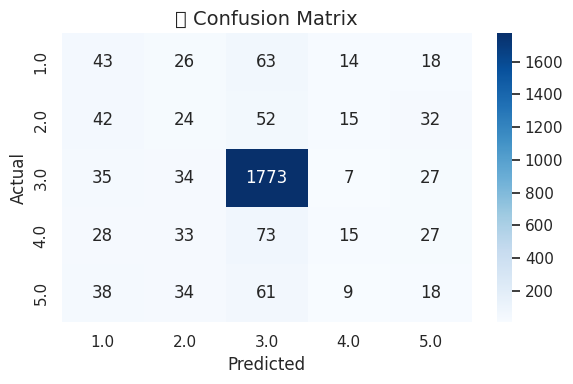

/tmp/ipython-input-3933434936.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_sorted.head(10), x='Importance', y='Feature', palette='Blues_r')
/tmp/ipython-input-3933434936.py:70: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


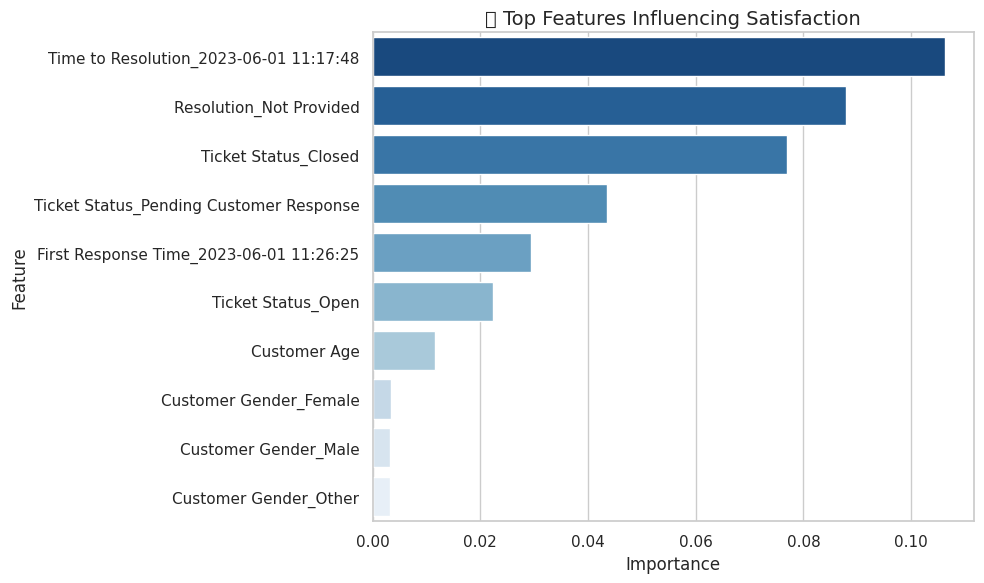

/tmp/ipython-input-3933434936.py:84: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


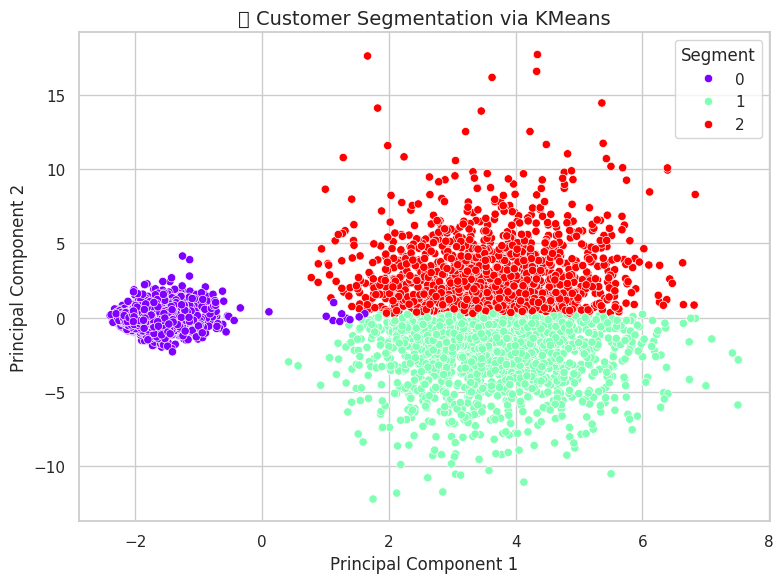


💡 Key Insight: Most influential feature → Time to Resolution_2023-06-01 11:17:48 (Importance: 0.106)
📈 Model Accuracy: 73.71% in predicting satisfaction levels.
📊 Segmentation reveals 3 clusters for targeting customer strategies.


In [ ]:
# Step 0: Upload CSV
from google.colab import files
uploaded = files.upload()

# Step 1: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 2: Load the file
file_name = list(uploaded.keys())[0]
cleaned_data = pd.read_csv(file_name)

# Step 3: Prepare features and target
X = cleaned_data.drop(['Ticket ID','Customer Name','Customer Email','Customer Satisfaction Rating'], axis=1)
y = cleaned_data['Customer Satisfaction Rating']

# Handle categorical features
X = pd.get_dummies(X)

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Step 5: Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = model.predict(X_test)
print(f"🎯 Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

# Step 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.title("🔹 Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()



# Step 8: Feature Importance
importances = model.feature_importances_
feature_labels = X.columns
feat_imp = pd.DataFrame({'Feature': feature_labels, 'Importance': importances})
feat_imp_sorted = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_sorted.head(10), x='Importance', y='Feature', palette='Blues_r')
plt.title("🔹 Top Features Influencing Satisfaction")
plt.tight_layout(); plt.show()

# Step 9: Clustering for Segmentation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='rainbow')
plt.title("🔹 Customer Segmentation via KMeans")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Segment')
plt.tight_layout(); plt.show()

# Step 10: Key Insights
top_feature = feat_imp_sorted.iloc[0]
print(f"\n💡 Key Insight: Most influential feature → {top_feature['Feature']} (Importance: {round(top_feature['Importance'],3)})")
print(f"📈 Model Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}% in predicting satisfaction levels.")
print("📊 Segmentation reveals 3 clusters for targeting customer strategies.")


Saving cleaned_customer_support.csv to cleaned_customer_support (5).csv
🎯 Model Accuracy: 73.71%

📋 Classification Report:
              precision    recall  f1-score   support

         1.0       0.23      0.26      0.25       164
         2.0       0.16      0.15      0.15       165
         3.0       0.88      0.95      0.91      1876
         4.0       0.25      0.09      0.13       176
         5.0       0.15      0.11      0.13       160

    accuracy                           0.74      2541
   macro avg       0.33      0.31      0.31      2541
weighted avg       0.70      0.74      0.71      2541



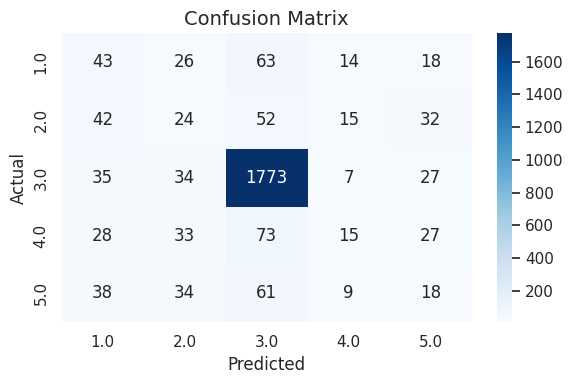

/tmp/ipython-input-663864050.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_sorted.head(10), x='Importance', y='Feature', palette='Blues_r')


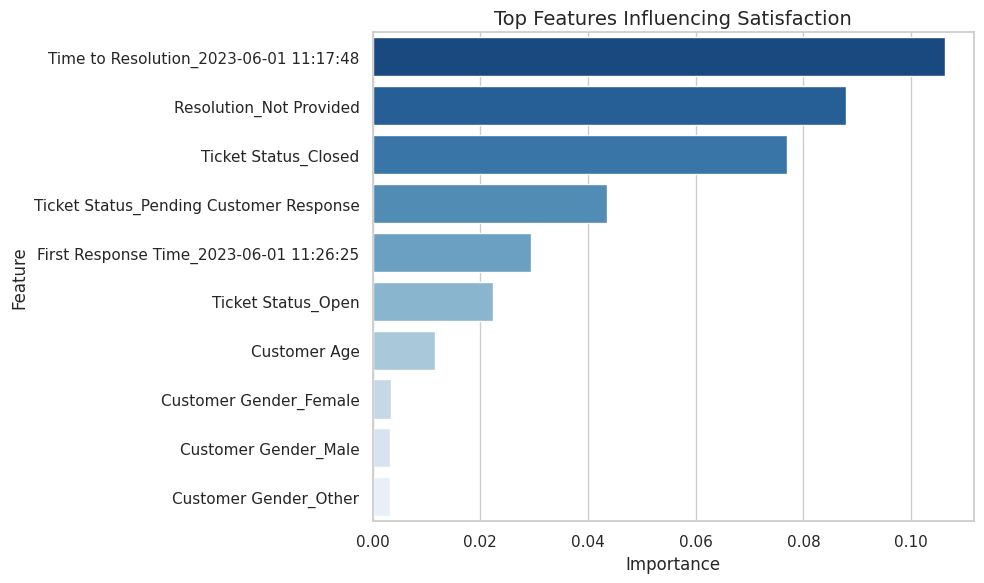

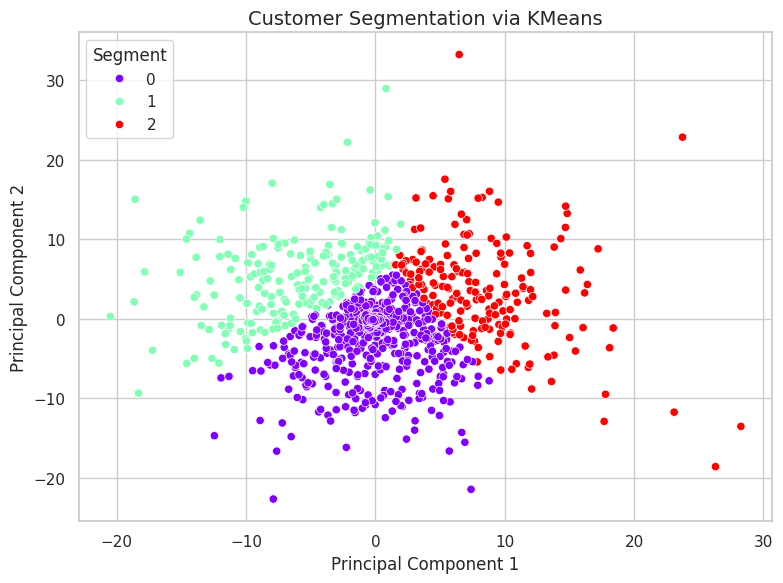

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔍 Key Insights:
- Most influential feature → Time to Resolution_2023-06-01 11:17:48 (Importance: 0.106)
- Model Accuracy → 73.71%
- Segmentation reveals 3 clusters for tailored customer engagement.


In [ ]:
# Step 0: Upload CSV
from google.colab import files
uploaded = files.upload()

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 2: Load CSV
filename = list(uploaded.keys())[0]
cleaned_data = pd.read_csv(filename)

# Step 3: Prepare Features & Target
X = cleaned_data.drop(['Ticket ID','Customer Name','Customer Email','Customer Satisfaction Rating'], axis=1)
y = cleaned_data['Customer Satisfaction Rating']
X = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['Ticket ID'] = cleaned_data['Ticket ID']  # Keep track of IDs

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_encoded, test_size=0.3, random_state=42)

# Step 5: Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train.drop(['Ticket ID'], axis=1), y_train)
y_pred = model.predict(X_test.drop(['Ticket ID'], axis=1))

# Step 6: Evaluate Performance
print(f"🎯 Model Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_.astype(str),
            yticklabels=le.classes_.astype(str))
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# Step 7: Feature Importance
importances = model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp_sorted = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_sorted.head(10), x='Importance', y='Feature', palette='Blues_r')
plt.title("Top Features Influencing Satisfaction")
plt.tight_layout(); plt.show()

# Step 8: PCA + KMeans on Test Data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test.drop(['Ticket ID'], axis=1))
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='rainbow')
plt.title("Customer Segmentation via KMeans")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Segment')
plt.tight_layout(); plt.show()

# Step 9: Export Results
results_df = pd.DataFrame({
    'Ticket ID': X_test['Ticket ID'].values,
    'Actual Satisfaction': le.inverse_transform(y_test),
    'Predicted Satisfaction': le.inverse_transform(y_pred),
    'Cluster': clusters
})
results_df.to_csv("customer_predictions_output.csv", index=False)
files.download("customer_predictions_output.csv")

# Step 10: Key Insights
top_feature = feat_imp_sorted.iloc[0]
print("\n🔍 Key Insights:")
print(f"- Most influential feature → {top_feature['Feature']} (Importance: {round(top_feature['Importance'],3)})")
print(f"- Model Accuracy → {round(accuracy_score(y_test, y_pred)*100,2)}%")
print("- Segmentation reveals 3 clusters for tailored customer engagement.")
